# UMAP 

### Installing and loading libraries

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
from plot_functions import mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore

### Setting constants

Setting project, input and output folders.

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

DF_DICT = {}
for dftype in ['full', 'reduced', 'balanced']:
    DF_DICT[dftype] = os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl")

### Functions

# UMAP projection

## Preparation

### Choose dataset

In [4]:
#dftype='full'
dftype='reduced'
#dftype='balanced'

spec_df = pd.read_pickle(DF_DICT[dftype])
spec_df.shape

(6430, 28)

### Choose feature

In [6]:
specs = spec_df.spectrograms.copy()

### Normalize feature

In [15]:
specs = [calc_zscore(x) for x in specs]

### Pad feature

In [28]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

In [29]:
data.shape

(6430, 5360)

## Run UMAP

In [30]:
reducer = umap.UMAP(n_components = 5, min_dist=0, metric='euclidean', random_state=2204)
embedding = reducer.fit_transform(data) 

## Visualization

### 3D Plots

#### Matplotlib 

In [10]:
labels = spec_df.call_lable.values
pal="Set2"

In [64]:
shuffled_labels = spec_df.call_lable.values.copy()
np.random.shuffle(shuffled_labels)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-05-11_UMAP_plot_reduced.jpg


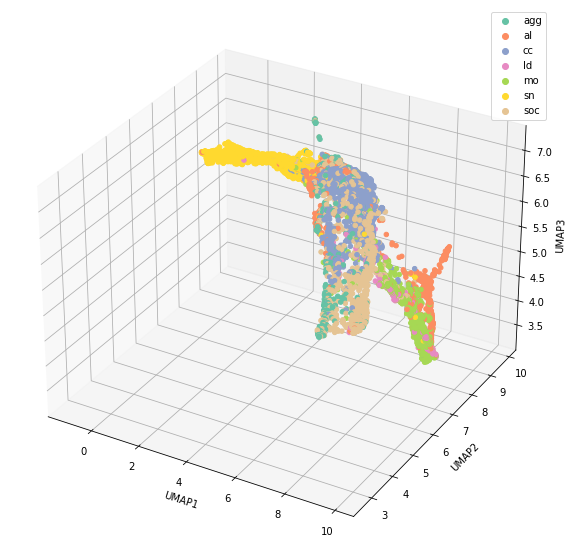

In [59]:
outname=os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_plot_'+dftype+'.jpg')
print(outname)

mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            labels,
            pal,
            outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-05-11_UMAP_plot_reduced.jpg


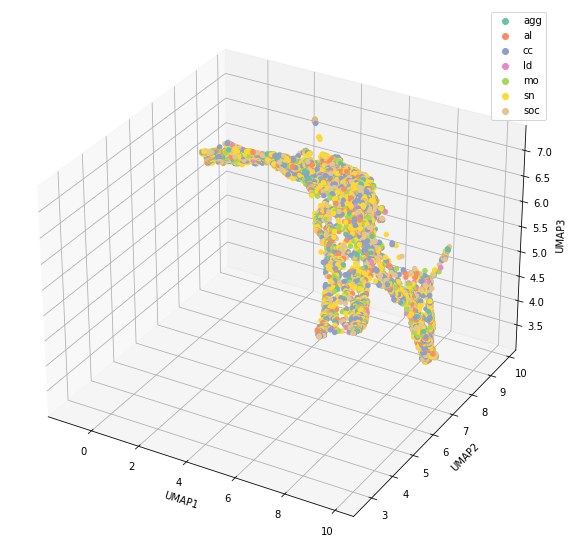

In [66]:
outname=os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_plot_'+dftype+'.jpg')
print(outname)

mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            shuffled_labels,
            pal,
            outname)

#### Plotly

In [26]:
plotly_viz(embedding[:,0],
           embedding[:,1],
           embedding[:,2],
           labels,
           pal)

### 2D plots

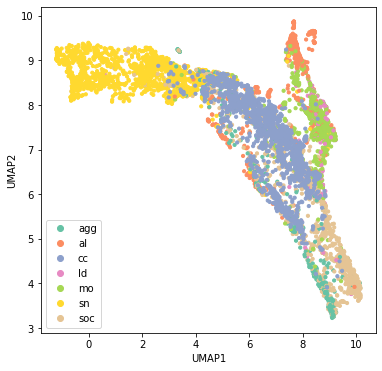

In [17]:
# 2D plot

fig = plt.figure(figsize=(6,6))
scat_labels = spec_df.call_lable.values
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

plt.scatter(embedding[:,0], embedding[:,1], alpha=1,
            s=10, c=c)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2');

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))
plt.legend(scatters, labeltypes, numpoints = 1)
plt.show()

In [18]:
np.savetxt('basic_UMAP_default_params.csv', embedding, delimiter=";")   

# Embedding evaluation

Evaluate the embedding. Since it's unsupervised, this is really difficult. Best would be to have a measure of dissimilarity that we trust but there's no obvious choice. VGG Net similarity would be an option.

Thus, for now, evaluate it based on the labelled calls.

In [67]:
from evaluation_functions import nn

In [13]:
nn_stats = nn(embedding, np.asarray(spec_df.call_lable), k=5)

In [14]:
nn_stats.get_statstab()

agg         al         cc         ld         mo         sn  \
agg      45.013333   2.453333  12.640000   0.160000   1.386667   3.306667   
al        1.950464  70.402477   8.266254   1.176471   9.287926   5.386997   
cc        2.789438   2.626947  78.226134   0.731212   1.841571   3.344617   
ld        0.609756   4.878049   9.512195  24.390244  45.000000   1.951220   
mo        0.711462   8.089592   4.611331   8.142292  70.988142   2.714097   
sn        0.539084   1.973046   2.835580   0.086253   0.873315  91.784367   
soc      11.958406   1.854419  15.892548   1.871750   2.807626   3.604853   
overall   5.832037  10.046656  22.970451   2.550544  11.804044  28.849145   

               soc  
agg      35.040000  
al        3.529412  
cc       10.440081  
ld       13.658537  
mo        4.743083  
sn        1.908356  
soc      62.010399  
overall  17.947123

## Calculate metrics

In [16]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

Log final metric (unweighted): 63.25929936490054
Abs final metric (unweighted): 2.404180612651549


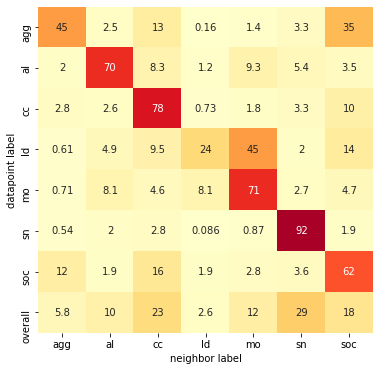

In [18]:
nn_stats.plot_heat_S()

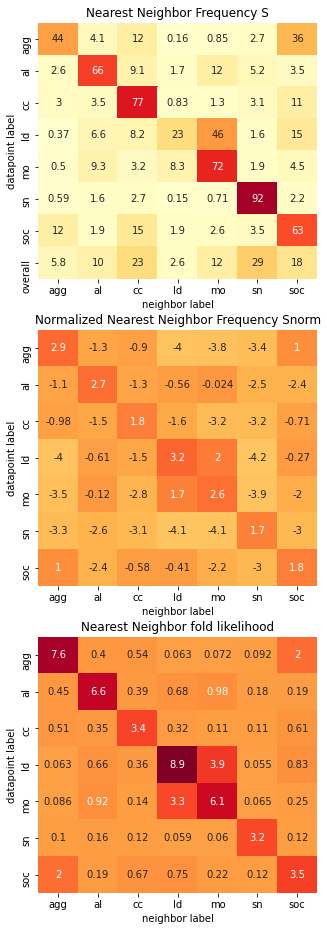

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize=(5,16))

plt.subplot(3, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, vmin=0, vmax=100, center=50, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.title("Nearest Neighbor Frequency S")

plt.subplot(3, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=1, vmin=-13, vmax=13, annot=True, cmap='YlOrRd', cbar=None)
plt.title("Normalized Nearest Neighbor Frequency Snorm")
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")


plt.subplot(3, 1, 3)
ax=sns.heatmap(np.power(2,stats_tab_norm), center=1, annot=True, cmap='YlOrRd',cbar=None)
plt.title("Nearest Neighbor fold likelihood")
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()


plt.tight_layout()

(0.0, 25.0)

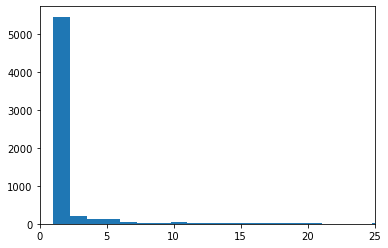

In [191]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(y, bins=1000)
plt.xlim(0,25)

# Within vs. outside distances

In [85]:
from scipy.spatial.distance import pdist, squareform

In [86]:
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

In [87]:
distmat_embedded = squareform(pdist(embedding, metric='euclidean'))

In [88]:
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
    x=distmat_embedded[np.where(labels==calltype)]
    x = np.transpose(x)
    
    y = x[np.where(labels==calltype)].flatten()
    
    self_dists[calltype] =  y[0:int(y.shape[0]/2)]
    other_dists[calltype] = x[np.where(labels!=calltype)].flatten()

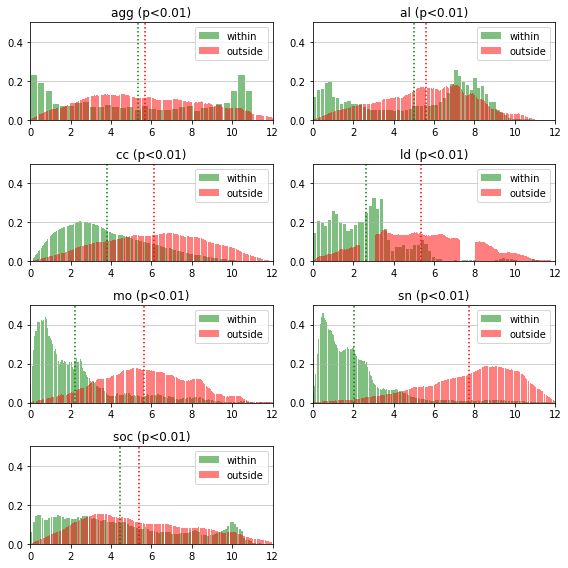

In [92]:
plt.figure(figsize=(8, 8))
i=1
for calltype in calltypes:
    plt.subplot(4, 2, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              bins='auto', color='green',
                              alpha=0.5, rwidth=0.85)
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="outside", density=True,
                              bins='auto', color='red',
                              alpha=0.5, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
    s, pval = scipy.stats.ttest_ind(self_dists[calltype],other_dists[calltype])

    if pval<0.01:
        pval = "p<0.01"
    else:
        pval = "p="+str(round(pval,2))

    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.title(calltype+" ("+pval+")")
    plt.xlim(0,12)
    plt.ylim(0, 0.5)

    i=i+1

plt.tight_layout()
#plt.savefig(FIGURES+'within_oustide_fancy.png')

## Silhouette Plot

In [97]:
from sklearn.metrics import silhouette_samples, silhouette_score

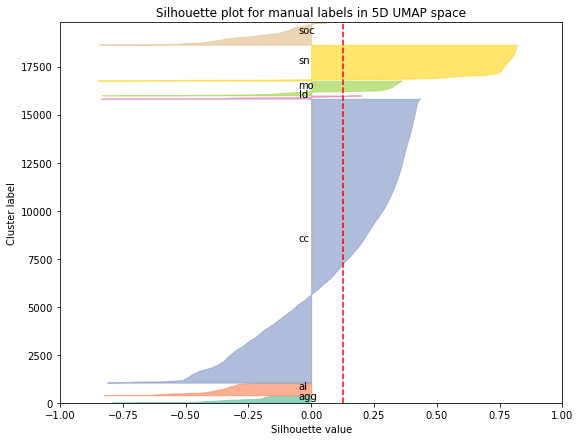

In [101]:
labels = umap_df.call_lable
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(9, 7)

ax1.set_xlim([-1, 1])

ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for manual labels in 5D UMAP space")
ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

In [ ]:
# Original % with neg scores
sample_silhouette_values = silhouette_samples(data, cluster_labels)
print(sample_silhouette_values[sample_silhouette_values<=0].shape[0]/sample_silhouette_values.shape[0])

0.4964857185583969


In [ ]:
# UMAP % with neg scores
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
print(sample_silhouette_values[sample_silhouette_values<=0].shape[0]/sample_silhouette_values.shape[0])

0.32899656049050396


Sil scores and % with negative scores as unweighted average per class

In [102]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

prop_neg_dict_UMAP = {}
sil_UMAP ={}

#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
    neg_vals = ith_cluster_silhouette_values[ith_cluster_silhouette_values<=0]
    print(cluster_label, ": ", neg_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100)
    prop_neg_dict_UMAP[cluster_label] = neg_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100
    sil_UMAP[cluster_label] = np.mean(ith_cluster_silhouette_values)


agg :  100.0
al :  100.0
cc :  31.09215248154919
ld :  58.536585365853654
mo :  24.110671936758894
sn :  3.5040431266846364
soc :  93.15424610051993


# Embedding evaluation 2: same vs. different group distances

Evaluate an embedding based on the ratio of distance of a point to all other points of the same label vs. to all other points of other labels

In [ ]:
nn_stats_dict

{'agg': array([[0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 1., ..., 0., 0., 2.],
        [0., 0., 1., ..., 0., 0., 2.],
        ...,
        [3., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 2.],
        [3., 0., 0., ..., 0., 0., 0.]]),
 'al': array([[0., 2., 1., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 2.]]),
 'cc': array([[0., 0., 2., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 2., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 2.],
        [0., 0., 0., ..., 0., 0., 3.],
        [0., 0., 0., ..., 0., 0., 3.]]),
 'ld': array([[0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0., ..., 2., 1., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 2., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 3., 0., 0.],
        [0., 0., 0.,

In [ ]:
k=3

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
maj_vote_dict = {}

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  n_calls = len(call_indices)
  point_label = calltype
  point_in_majority = 0
  no_majority = 0

  for ind in call_indices:
    nearest_neighbors = indices[ind]
    neighbor_labels = [labels[x] for x in nearest_neighbors]
    most_frequent = Counter(neighbor_labels).most_common(1)

    # is there a majority?
    if most_frequent[0][1] > 1:
      majority_vote = most_frequent[0][0]
      if majority_vote == point_label:
        point_in_majority += 1
    else:
      no_majority += 1

  maj_vote_dict[calltype] = [point_in_majority, no_majority, n_calls]
  # normalize to random probability to have majority vote of same calltype!
  # What is the probability of having >k/2 

  # lead: 0.2%
  # p(4 leads in 8 pulls) = (0.2)^4*(1-0.2)^4 * all possible combinations of arranging 8 items

maj_vote_dict

{'agg': [203, 56, 491],
 'al': [475, 76, 748],
 'cc': [1114, 195, 1936],
 'ld': [19, 38, 208],
 'mo': [636, 144, 995],
 'sn': [1610, 102, 1947],
 'soc': [2508, 291, 3499]}

In [ ]:
calltype = 'sn'
point_label = calltype
call_indices = np.asarray(np.where(labels==calltype))[0]
len(call_indices)
ind = call_indices[10]
nearest_neighbors = indices[ind]
neighbor_labels = [labels[x] for x in nearest_neighbors]
neighbor_labels

['sn', 'sn', 'sn']

In [ ]:
Counter(neighbor_labels).most_common(1)

[('sn', 3)]

In [ ]:
#from collections import Counter

l = ['dog', 'monkey', 'jimbo']
most_frequent = Counter(l).most_common(1)



In [ ]:
most_frequent[0][0]

'dog'

In [ ]:
neighbor_labels

['soc', 'soc', 'soc']

# Embedding evaluation 3: VGG Net similarity of nearest neighbors

Use VGG Net predicted image similarity of spectrograms as ground truth (This will not always be a good idea). 

# Embedding Optimization

Grid search with different parameters to find the best embedding.
Parameters: 
* UMAP parameters (min_dist, spread, metric)
* inputs (stretched, denoised, MFCC etc)
* adding duration as dimension or not

In [ ]:
def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall


  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  x = stats_tab_norm.replace(0,0.0001)
  stats_tab_norm = np.log2(x)

  #stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['cosine']
n_components_list = [2,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
              'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [ ]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'
spec_df = spec_df[spec_df.nonfocal_yn == 'n']
dftype='focal'

labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
  overall[i] = sum(labels==calltype)
overall = (overall/np.sum(overall))*100


f = open("UMAP_optimization_2020-10-26_cosine.txt","w+")
header = ['k',
          'min_dist',
          'spread',
          'metric',
          'n_components',
          'input_var',
          'add_duration',
          'normalize',
          'mean_log_unweighted', 
          'mean_log_weighted',
          'mean_abs_unweighted',
          'mean_abs_weighted']
header = header+calltypes+calltypes
header_str = ";".join(header)
f.write(header_str+"\r\n")
f.close()

In [ ]:
%pwd

'/content/drive/My Drive/meerkat'

In [ ]:
# Example with one:
k=10
MIN_DIST = 0
SPREAD = 1
METRIC = 'euclidean'
N_COMPONENTS = 2
INPUT_VAR = 'denoised_spectrograms'
ADD_DURATION = True
NORMALIZE = False


# Open file
#f = open("UMAP_optimization.txt","w+")
f = open("UMAP_optimization_2020-10-26.txt", "w+")

# Select input data
print('\rPreparing data...',end='')
specs = np.asarray(spec_df[INPUT_VAR])
method = INPUT_VAR

# Flatten and pad with zeros
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

if NORMALIZE:
  data = StandardScaler().fit_transform(pd.DataFrame(data))

# Run UMAP
print('\rRunning UMAP...',end='')
reducer = umap.UMAP(low_memory=True, 
                    n_components = N_COMPONENTS, 
                    metric = METRIC, 
                    min_dist = MIN_DIST,
                    spread = SPREAD)
embedding = reducer.fit_transform(data)

# Get nearest neighbors
print('\rGetting nearest neighbors...',end='')
indices, distances = get_knn(k,embedding)

# count neighbor labels
print('\rCounting neighbor labels...',end='')
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

# Make statstabs
print('\rMaking statstabs...',end='')
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

# Write results to file
print('\rWrite to file...',end='')

#f = open("UMAP_optimization.txt","w+")
f = open("UMAP_optimization_2020-10-26.txt","w+")


params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
params_str = ';'.join([str(x) for x in params])

# Metrics
mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                           np.average(np.diagonal(stats_tab_norm), weights=overall),
                           np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                           np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
all_metrics = np.concatenate((mean_metrics,
                np.diagonal(stats_tab_norm), 
                np.diagonal(stats_tab)))

all_metrics_str = np.char.mod('%f', all_metrics)
all_metrics_str = ";".join(all_metrics_str)

all_results_str = params_str+";"+all_metrics_str
f.write(all_results_str+"\r\n")
f.close()

print('\rDone!',end='')

Done!

Grid search:

In [ ]:
spec_df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df['index_id'] = spec_df.index
dftype = 'balanced'

spec_df = spec_df[spec_df.nonfocal_yn == 'n']
dftype='focal'


labels = spec_df.call_lable.values
calltypes = sorted(list(set(spec_df.call_lable.values)))

In [ ]:
k=10
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['cosine']
n_components_list = [2,10]

input_vars = ['spectrograms',  'stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 
          'mfccs','stretched_mfccs','denoised_mfccs', 'denoised_stretched_mfccs']

normalize_list = [True, False]

In [ ]:
for input_var in input_vars:
  for normalize in normalize_list:
    for min_dist in min_dists:
      for metric in metrics:
        for spread in spreads:
          for n_components in n_components_list:
              print(input_var, normalize, min_dist, metric, spread, n_components)

              # Select input data
              print('\rPreparing data...',end='')
              specs = np.asarray(spec_df[input_var])

              # Flatten and pad with zeros
              maxlen= np.max([spec.shape[1] for spec in specs])
              flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
              data = np.asarray(flattened_specs)

              if normalize:
                data = StandardScaler().fit_transform(pd.DataFrame(data))

              # Run UMAP
              print('\rRunning UMAP...',end='')
              reducer = umap.UMAP(low_memory=True, 
                                  n_components = n_components, 
                                  metric = metric, 
                                  min_dist = min_dist,
                                  spread = spread)
              embedding = reducer.fit_transform(data)

              add_duration = False

              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              #f = open("UMAP_optimization_cosine.txt","a")
              f = open("UMAP_optimization_2020-10-26_cosine.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n')  

              add_duration = True
              embedding_df = pd.DataFrame(embedding)
              embedding_df['duration'] = spec_df.duration_s.values
              embedding = np.asarray(embedding_df)     


              # Get nearest neighbors
              print('\rGetting nearest neighbors...',end='')
              indices, distances = get_knn(k,embedding)

              # count neighbor labels
              print('\rCounting neighbor labels...',end='')
              nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)

              # Make statstabs
              print('\rMaking statstabs...',end='')
              stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

              # Write results to file
              print('\rWrite to file...',end='')
              #f = open("UMAP_optimization_cosine.txt","a")
              f = open("UMAP_optimization_2020-10-26_cosine.txt","a")

              params = [k, min_dist, spread, metric, n_components, input_var, add_duration, normalize]
              params_str = ';'.join([str(x) for x in params])

              # Metrics
              mean_metrics = np.asarray([np.mean(np.diagonal(stats_tab_norm)),
                                        np.average(np.diagonal(stats_tab_norm), weights=overall),
                                        np.mean(np.diagonal(stats_tab.iloc[:-1,])),
                                        np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)])
              all_metrics = np.concatenate((mean_metrics,
                              np.diagonal(stats_tab_norm), 
                              np.diagonal(stats_tab)))

              all_metrics_str = np.char.mod('%f', all_metrics)
              all_metrics_str = ";".join(all_metrics_str)

              all_results_str = params_str+";"+all_metrics_str
              f.write(all_results_str+"\r\n")
              f.close()

              print('\rDone!',end='\n') 



spectrograms True 0 cosine 1 2
Done!
Done!
spectrograms True 0 cosine 1 10
Done!
Done!
spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms True 0.1 cosine 1 2
Done!
Done!
spectrograms True 0.1 cosine 1 10
Done!
Done!
spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0 cosine 1 2
Done!
Done!
spectrograms False 0 cosine 1 10
Done!
Done!
spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0.1 cosine 1 2
Done!
Done!
spectrograms False 0.1 cosine 1 10
Done!
Done!
spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0 cosine 1 2
Done!
Done!
stretched_spectrograms True 0 cosine 1 10
Done!
Done!
stretched_spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0.1 cosine 1 2
Done!
Done!
stretched_spectrograms True 0.1 cosine 1 10
Done!
Done!
stretched_spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0 cosine 1 2
Done!
Done!
stretched_spectrograms False 0 cosine 1 10
Done!
Done!
stretched_spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0.1 cosine 1 2
Done!
Done!
stretched_spectrograms False 0.1 cosine 1 10
Done!
Done!
stretched_spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0 cosine 1 2
Done!
Done!
denoised_spectrograms True 0 cosine 1 10
Done!
Done!
denoised_spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0.1 cosine 1 2
Done!
Done!
denoised_spectrograms True 0.1 cosine 1 10
Done!
Done!
denoised_spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0 cosine 1 2
Done!
Done!
denoised_spectrograms False 0 cosine 1 10
Done!
Done!
denoised_spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0.1 cosine 1 2
Done!
Done!
denoised_spectrograms False 0.1 cosine 1 10
Done!
Done!
denoised_spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms True 0 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms False 0 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 1 2
Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 1 10
Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_spectrograms False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0 cosine 1 2
Done!
Done!
mfccs True 0 cosine 1 10
Done!
Done!
mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0.1 cosine 1 2
Done!
Done!
mfccs True 0.1 cosine 1 10
Done!
Done!
mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0 cosine 1 2
Done!
Done!
mfccs False 0 cosine 1 10
Done!
Done!
mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0.1 cosine 1 2
Done!
Done!
mfccs False 0.1 cosine 1 10
Done!
Done!
mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0 cosine 1 2
Done!
Done!
stretched_mfccs True 0 cosine 1 10
Done!
Done!
stretched_mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0.1 cosine 1 2
Done!
Done!
stretched_mfccs True 0.1 cosine 1 10
Done!
Done!
stretched_mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0 cosine 1 2
Done!
Done!
stretched_mfccs False 0 cosine 1 10
Done!
Done!
stretched_mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0.1 cosine 1 2
Done!
Done!
stretched_mfccs False 0.1 cosine 1 10
Done!
Done!
stretched_mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
stretched_mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0 cosine 1 2
Done!
Done!
denoised_mfccs True 0 cosine 1 10
Done!
Done!
denoised_mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0.1 cosine 1 2
Done!
Done!
denoised_mfccs True 0.1 cosine 1 10
Done!
Done!
denoised_mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0 cosine 1 2
Done!
Done!
denoised_mfccs False 0 cosine 1 10
Done!
Done!
denoised_mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0.1 cosine 1 2
Done!
Done!
denoised_mfccs False 0.1 cosine 1 10
Done!
Done!
denoised_mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0 cosine 1 2
Done!
Done!
denoised_stretched_mfccs True 0 cosine 1 10
Done!
Done!
denoised_stretched_mfccs True 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 1 2
Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 1 10
Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs True 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0 cosine 1 2
Done!
Done!
denoised_stretched_mfccs False 0 cosine 1 10
Done!
Done!
denoised_stretched_mfccs False 0 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 1 2
Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 1 10
Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 5 2
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!
denoised_stretched_mfccs False 0.1 cosine 5 10
Running UMAP...

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



Done!
Done!


## Analyzing grid search results

In [ ]:
k=5
min_dists = [0,0.1] # (default 0.1), smaller values will result in clumpier embeddings
spreads = [1,5] # (scale of embedded points, default 1.0)
metrics = ['euclidean', 'cosine']
n_components_list = [2,10]
input_vars = ['spectrograms', 'denoised_spectrograms', 'stretched_spectrograms', 'stretched_denoised_spectrograms', 
              'mfccs','denoised_mfccs','stretched_mfccs', 'denoised_stretched_mfccs']
add_durations = [True, False]
normalize_list = [True, False]

In [ ]:
import scipy.stats as stats

opti_table_all = pd.read_csv(PROJECT_PATH+'UMAP_optimization.txt', sep=";", header=0)

opti_table_euclid = pd.read_csv(PROJECT_PATH+'UMAP_optimization_2020-10-26.txt', sep=";", header=0)
opti_table_cosine = pd.read_csv(PROJECT_PATH+'UMAP_optimization_2020-10-26_cosine.txt', sep=";", header=0)
opti_table_all = pd.concat([opti_table_euclid, opti_table_cosine])
#opti_table = opti_table_all.loc[opti_table_all['metric']=='euclidean']
#opti_table = opti_table[opti_table.input_var.isin(['spectrograms', 'denoised_spectrograms', 'denoised_stretched_spectrograms', 'stretched_spectrograms'])]
var_of_interest = 'mean_abs_unweighted'

In [ ]:
opti_table = opti_table_all.iloc[:,0:12]

In [ ]:
# use only euclidean
opti_table = opti_table.loc[opti_table_all['metric']=='euclidean']

In [ ]:
opti_table

k  min_dist  ...  mean_abs_unweighted mean_abs_weighted
0    10       0.0  ...            44.877835         54.217053
1    10       0.0  ...            44.418666         53.852227
2    10       0.0  ...            46.232075         55.786787
3    10       0.0  ...            46.089626         55.724032
4    10       0.0  ...            45.482199         54.953906
..   ..       ...  ...                  ...               ...
251  10       0.1  ...            61.982468         72.410648
252  10       0.1  ...            54.868883         65.048602
253  10       0.1  ...            58.777208         70.022432
254  10       0.1  ...            58.333907         68.157619
255  10       0.1  ...            61.910535         72.421116

[512 rows x 12 columns]

In [ ]:
opti_table_all

k  min_dist  spread  ...       mo.1       sn.1      soc.1
0    10       0.0       1  ...  45.765550  88.617757  45.228758
1    10       0.0       1  ...  43.648325  88.654971  44.697712
2    10       0.0       1  ...  48.887560  89.191919  47.434641
3    10       0.0       1  ...  48.528708  89.218501  47.352941
4    10       0.0       5  ...  47.703349  88.437002  47.099673
..   ..       ...     ...  ...        ...        ...        ...
251  10       0.1       1  ...  68.289474  91.786284  59.665033
252  10       0.1       5  ...  62.763158  86.092504  51.960784
253  10       0.1       5  ...  64.904306  92.636895  56.053922
254  10       0.1       5  ...  64.665072  86.507177  57.459150
255  10       0.1       5  ...  67.978469  91.982988  59.591503

[512 rows x 26 columns]

In [ ]:
opti_table['input_var'].value_counts()

denoised_mfccs                     64
denoised_stretched_spectrograms    64
spectrograms                       64
denoised_stretched_mfccs           64
stretched_mfccs                    64
mfccs                              64
denoised_spectrograms              64
stretched_spectrograms             64
Name: input_var, dtype: int64

In [ ]:
opti_table['metric'].value_counts()

euclidean    256
cosine       256
Name: metric, dtype: int64

In [ ]:
opti_table['min_dist'].value_counts()

0.1    256
0.0    256
Name: min_dist, dtype: int64

In [ ]:
opti_table['k'].value_counts()

10    256
Name: k, dtype: int64

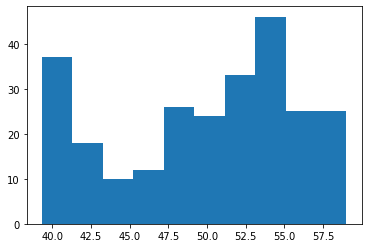

In [ ]:
n, bins, patches = plt.hist(opti_table['mean_abs_unweighted'])

In [ ]:
import scipy.stats as stats

var_of_interest = 'mean_abs_unweighted'
#var_of_interest = 'mean_abs_weighted'
group_var = 'input_var'


#res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
#               opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]
#               )
#print(group_var, ":", res.pvalue)

group_var = 'normalize'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'add_duration'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == True],
                      opti_table[var_of_interest][opti_table[group_var] == False]
                      )
print(group_var, ":", res.pvalue)

group_var = 'min_dist'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'spread'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]],
                      )
print(group_var, ":", res.pvalue)

group_var = 'n_components'
res = stats.f_oneway(opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
                      opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]],
                      )
print(group_var, ":", res.pvalue)

normalize : 6.037038115314089e-10
add_duration : 0.004870769489828951
min_dist : 0.9660873638528836
spread : 0.39166160986124776
n_components : 1.0014073595181901e-08


In [ ]:
ll = 40
ul = 70

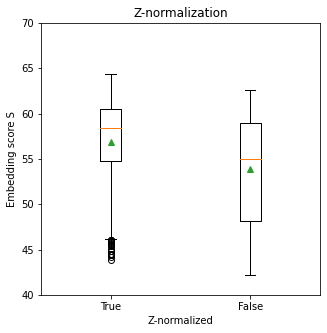

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'normalize'
data = [opti_table[var_of_interest][opti_table[group_var] == normalize_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  normalize_list[1]]]


ax.boxplot(data,
           labels= normalize_list,
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Z-normalized")
plt.title("Z-normalization")
plt.ylabel("Embedding score S")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')


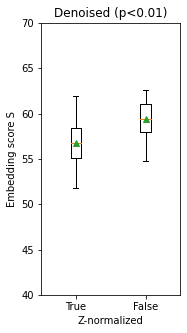

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'normalize'

subset_denoised = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'denoised_spectrograms', 'denoised_stretched_MFCCs', 'denoised_MFCCs'])]
subset_not_denoised = opti_table[opti_table.input_var.isin(['stretched_spectrograms', 'spectrograms', 'stretched_MFCCs', 'MFCCs'])]

var_of_interest = 'mean_abs_unweighted'
data = [subset_denoised[var_of_interest][subset_denoised[group_var] == True],
        subset_denoised[var_of_interest][subset_denoised[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Denoised ("+pval+")")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-6.318706425615156, pvalue=4.157410839613772e-09)

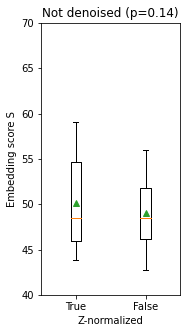

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

data = [subset_not_denoised[var_of_interest][subset_not_denoised[group_var] == True],
        subset_not_denoised[var_of_interest][subset_not_denoised[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Z-normalized")
plt.ylabel("Embedding score S")

s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Not denoised ("+pval+")")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'_2.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=1.892327578712484, pvalue=0.06311871948037019)

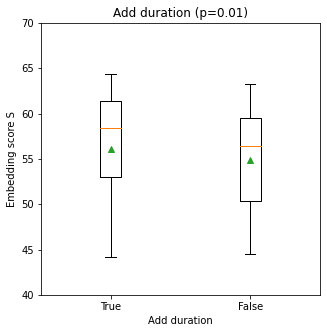

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'
data = [opti_table[var_of_interest][opti_table[group_var] == True],
        opti_table[var_of_interest][opti_table[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Add duration ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

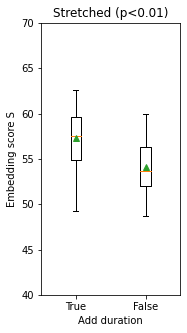

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'

subset_stretched = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'stretched_spectrograms'])]
subset_padded = opti_table[opti_table.input_var.isin(['denoised_spectrograms', 'spectrograms'])]

data = [subset_stretched[var_of_interest][subset_stretched[group_var] == True],
        subset_stretched[var_of_interest][subset_stretched[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Stretched ("+pval+")")



plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'_stretched.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=2.9984341732494557, pvalue=0.0039018195744512543)

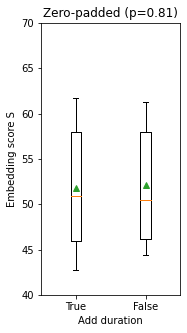

In [ ]:
fig = plt.figure(figsize= (2.5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'add_duration'

subset_stretched = opti_table[opti_table.input_var.isin(['denoised_stretched_spectrograms', 'stretched_spectrograms'])]
subset_padded = opti_table[opti_table.input_var.isin(['denoised_spectrograms', 'spectrograms'])]

data = [subset_padded[var_of_interest][subset_padded[group_var] == True],
        subset_padded[var_of_interest][subset_padded[group_var] ==  False]]


ax.boxplot(data,
           labels= [True, False],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("Add duration")
plt.ylabel("Embedding score S")
plt.title('Zero-padded')

s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("Zero-padded ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'_padded.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-0.026523466775960805, pvalue=0.9789250040896431)

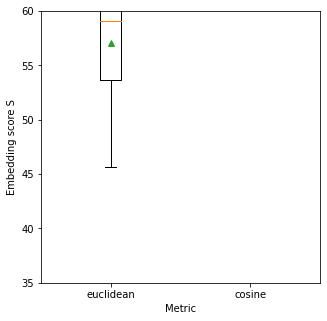

In [ ]:
# Effect of UMAP distance metric
# Need to filter because I tested the angular only on min_dist 0.1, spread 1, n_components 10


fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

dat1=opti_table_all.loc[(opti_table_all['metric'] == 'euclidean') & 
                   (opti_table_all['min_dist'] ==0.1) &
                   (opti_table_all['spread'] ==1) &
                   (opti_table_all['n_components'] ==10)]
dat1 = dat1[var_of_interest]

dat2 = opti_table_all.loc[(opti_table_all['metric'] == 'cosine') & 
                   (opti_table_all['min_dist'] ==0.1) &
                   (opti_table_all['spread'] ==1) &
                   (opti_table_all['n_components'] ==10)]
dat2 = dat2[var_of_interest]         

data = [dat1,dat2]


ax.boxplot(data,
           labels= ['euclidean', 'cosine'],
           showmeans= True)
plt.ylim([35,60])
plt.xlabel("Metric")
plt.ylabel("Embedding score S")



plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

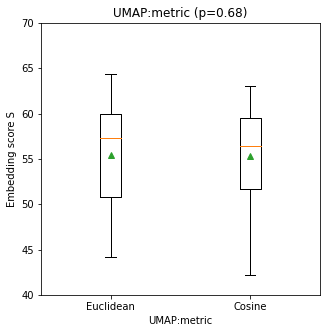

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'metric'
data = [opti_table[var_of_interest][opti_table[group_var] == 'euclidean'],
        opti_table[var_of_interest][opti_table[group_var] ==  'cosine']]


ax.boxplot(data,
           labels= ['Euclidean', 'Cosine'],
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("UMAP:metric")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("UMAP:metric ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(dat1,dat2)

Ttest_indResult(statistic=-0.4628033985310598, pvalue=0.6451255959842207)

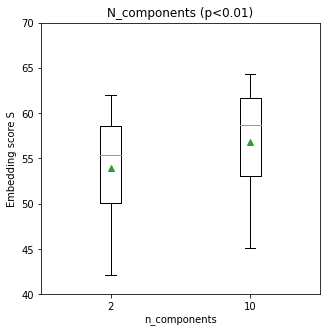

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

group_var = 'n_components'
data = [opti_table[var_of_interest][opti_table[group_var] == n_components_list[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  n_components_list[1]]]


ax.boxplot(data,
           labels= [n_components_list[0], n_components_list[1]],
           showmeans= True)
plt.ylim([ll,ul])
plt.xlabel("n_components")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("N_components ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=-3.9975925543689237, pvalue=8.39211679752964e-05)

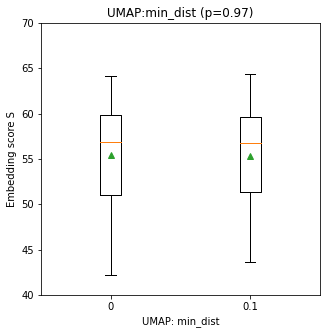

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'min_dist'
data = [opti_table[var_of_interest][opti_table[group_var] == min_dists[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  min_dists[1]]]


ax.boxplot(data,
           labels= min_dists,
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("UMAP: min_dist")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("UMAP:min_dist ("+pval+")")


plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
stats.ttest_ind(data[0],data[1])

Ttest_indResult(statistic=0.13838440101517765, pvalue=0.8900462712984369)

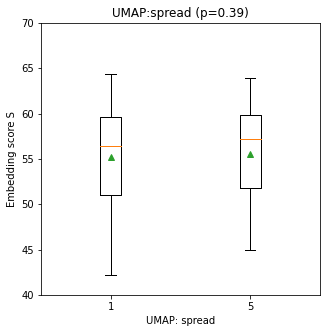

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set

var_of_interest = 'mean_abs_unweighted'
group_var = 'spread'
data = [opti_table[var_of_interest][opti_table[group_var] == spreads[0]],
        opti_table[var_of_interest][opti_table[group_var] ==  spreads[1]]]


ax.boxplot(data,
           labels= spreads,
           showmeans= True)

plt.ylim([ll,ul])
plt.xlabel("UMAP: spread")
plt.ylabel("Embedding score S")
s, pval = stats.ttest_ind(data[0],data[1])
if pval<0.01:
  pval = "p<0.01"
else:
  pval = "p="+str(round(pval,2))
plt.title("UMAP:spread ("+pval+")")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

In [ ]:
s, pval = stats.ttest_ind(data[0],data[1])
pval

0.6061877054552733

In [ ]:
input_vars

['mfccs']

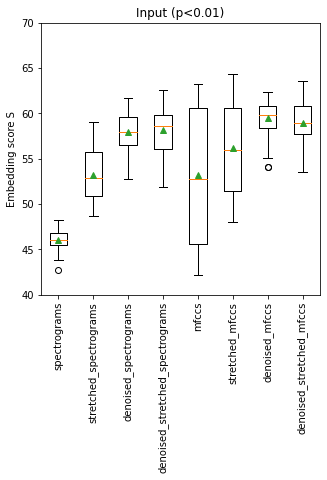

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

ax.set
group_var = 'input_var'
data = [opti_table[var_of_interest][opti_table[group_var] == input_vars[0]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[1]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[2]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[3]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[4]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[5]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[6]],
        opti_table[var_of_interest][opti_table[group_var] == input_vars[7]]]


ax.boxplot(data,
           labels= input_vars,
           showmeans= True)
plt.ylim([ll,ul])
plt.xlabel("")
plt.ylabel("Embedding score S")
plt.xticks(rotation=90)
plt.title("Input (p<0.01)")

plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+group_var+'.png')

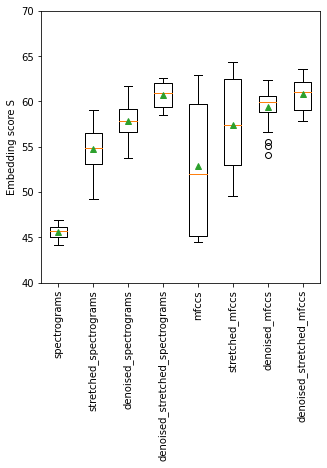

In [ ]:
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111)

opti_table_sub = opti_table[opti_table.add_duration==True]
ax.set
group_var = 'input_var'
data = [opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[0]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[1]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[2]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[3]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[4]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[5]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[6]],
        opti_table_sub[var_of_interest][opti_table_sub[group_var] == input_vars[7]]]


ax.boxplot(data,
           labels= input_vars,
           showmeans= True)
plt.ylim([ll,ul])
plt.xlabel("")
plt.ylabel("Embedding score S")
plt.xticks(rotation=90)

plt.show()

In [ ]:
opti_sorted = opti_table.sort_values(by=['mean_abs_unweighted'], ascending=False)
#opti_sorted.loc[opti_sorted['input_var']=='stretched_mfccs',:]

In [ ]:
opti_sorted.iloc[0:40,]

k  min_dist  ...  mean_abs_unweighted mean_abs_weighted
171  10       0.1  ...            64.326699         71.629137
163  10       0.0  ...            64.171100         71.429960
175  10       0.1  ...            63.932175         71.173364
167  10       0.0  ...            63.777893         71.068030
235  10       0.1  ...            63.534537         70.619661
130  10       0.0  ...            63.242753         70.261191
231  10       0.0  ...            63.114899         70.228528
239  10       0.1  ...            63.094785         70.257895
138  10       0.1  ...            63.026309         70.407286
142  10       0.1  ...            62.949828         69.815984
139  10       0.1  ...            62.934570         70.601350
131  10       0.0  ...            62.884653         70.342242
227  10       0.0  ...            62.728419         69.864580
134  10       0.0  ...            62.666793         69.728884
143  10       0.1  ...            62.661344         69.760680
127  10       0.1  ...            62.603959         70.371094
119  10       0.0  ...            62.577332         70.427229
123  10       0.1  ...            62.542984         70.022482
135  10       0.0  ...            62.403232         69.598867
195  10       0.0  ...            62.396532         69.487995
115  10       0.0  ...            62.344199         69.866056
203  10       0.1  ...            62.322797         69.595684
199  10       0.0  ...            62.170120         69.402950
165  10       0.0  ...            62.025249         69.689043
206  10       0.1  ...            61.983595         68.747580
207  10       0.1  ...            61.960930         69.205894
111  10       0.1  ...            61.927616         69.831304
251  10       0.1  ...            61.894282         68.823156
198  10       0.0  ...            61.868517         68.703311
174  10       0.1  ...            61.853125         68.351009
166  10       0.0  ...            61.818602         68.215765
202  10       0.1  ...            61.818050         68.868951
255  10       0.1  ...            61.815820         68.863247
194  10       0.0  ...            61.764546         68.798220
162  10       0.0  ...            61.724995         68.303509
247  10       0.0  ...            61.716030         68.717223
83   10       0.0  ...            61.681276         69.134936
161  10       0.0  ...            61.631188         69.944605
170  10       0.1  ...            61.623707         68.254107
173  10       0.1  ...            61.584185         69.563592

[40 rows x 12 columns]

In [ ]:
opti_table.columns

Index(['k', 'min_dist', 'spread', 'metric', 'n_components', 'input_var',
       'add_duration', 'normalize', 'mean_log_unweighted', 'mean_log_weighted',
       'mean_abs_unweighted', 'mean_abs_weighted'],
      dtype='object')

## How many dimensions?

Evaluate, how many dimensions are best for the embedding.

In [ ]:
embedding_filename = '2020-10-14_embedding_denoised_melspectro_balanced'
embedding_filename = '2020-20-26_embedding_denoised_melspectro_focal_10dims'
embedding = np.asarray(pd.read_pickle(DATA+embedding_filename))
embedding = np.asarray(embedding[:,0:10])

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']

In [ ]:
umap_df = spec_df

In [ ]:
k=5

In [ ]:
dims_tab = np.zeros((9,1))
labels = umap_df.call_lable.values
calltypes = sorted(list(set(labels)))

for n_dims in range(1,10):
  # Get nearest neighbors
  indices, distances = get_knn(k,embedding[:,0:n_dims])
  nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
  stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)
  
  mean_metric = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  print(mean_metric)
  dims_tab[n_dims-1,:] = mean_metric

34.92620506913381
49.43836447692416
59.37589233807086
61.93366574685317
62.047579605527844
62.300672020609106
62.27659145765519
62.01257833116335
62.2062926126217


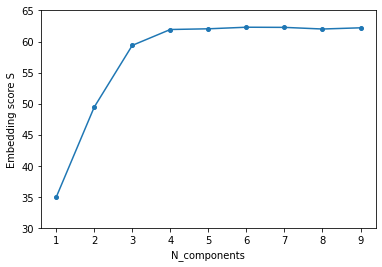

In [ ]:
x = np.arange(1,10,1)
y = dims_tab[:9,0]
plt.plot(x,y, marker='o', markersize=4)
plt.xlabel("N_components")
plt.ylabel("Embedding score S")
plt.ylim(30,65)
#plt.show()
plt.savefig(FIGURES+'n_dims.png')

# Graph from embedding evaluation

Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

In [ ]:
stats_tab_norm

agg        al        cc        ld        mo        sn       soc
agg  2.915297 -2.198610 -0.741042 -3.832458 -3.438827 -3.178117  0.938794
al  -2.488117  2.694885 -1.393385 -0.425301  0.231946 -2.628294 -2.344447
cc  -1.134384 -1.599836  1.778445 -1.313229 -2.744026 -3.301376 -0.585595
ld  -4.832458 -0.617946 -1.382770  3.323115  1.733423 -4.162607 -0.495405
mo  -3.207501 -0.031669 -2.275121  1.658848  2.434532 -2.739996 -2.170141
sn  -2.672882 -2.564164 -3.183271 -4.162607 -2.970609  1.691681 -2.994569
soc  0.793644 -2.429695 -0.371912 -0.530738 -2.248615 -2.968097  1.771306

In [ ]:
np.power(2,stats_tab_norm)

agg        al        cc         ld        mo        sn       soc
agg  7.543829  0.217847  0.598307   0.070196  0.092217  0.110482  1.916925
al   0.178239  6.475023  0.380671   0.744684  1.174418  0.161735  0.196902
cc   0.455529  0.329915  3.430562   0.402419  0.149268  0.101435  0.666374
ld   0.035098  0.651598  0.383482  10.008229  3.325157  0.055838  0.709362
mo   0.108254  0.978288  0.206595   3.157643  5.405890  0.149685  0.222189
sn   0.156813  0.169087  0.110088   0.055838  0.127573  3.230328  0.125471
soc  1.733448  0.185605  0.772758   0.692200  0.210426  0.127795  3.413629

In [ ]:
import graphviz
import networkx as nx
import string

!wget https://anaconda.org/anaconda/pygraphviz/1.3/download/linux-64/pygraphviz-1.3-py36h14c3975_1.tar.bz2
!tar xvjf pygraphviz-1.3-py36h14c3975_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import pygraphviz

In [ ]:
sim_mat = np.asarray(stats_tab_norm).copy()
#sim_mat = np.asarray(np.power(2,stats_tab_norm)).copy()
for i in range(sim_mat.shape[0]):
  for j in range(i,sim_mat.shape[0]):
    if i!=j:
      #sim_mat[i,j] = gmean((sim_mat[i,j], sim_mat[j,i]))
      sim_mat[i,j] = np.mean((sim_mat[i,j], sim_mat[j,i]))
      sim_mat[j,i] = sim_mat[i,j]
    else:
      sim_mat[i,j] = 0

In [ ]:
pd.DataFrame(sim_mat)

0         1         2         3         4         5         6
0  0.000000  0.197050  0.522060  0.049636  0.099914  0.131625  1.822879
1  0.197050  0.000000  0.354385  0.696588  1.071876  0.165370  0.191170
2  0.522060  0.354385  0.000000  0.392836  0.175608  0.105673  0.717597
3  0.049636  0.696588  0.392836  0.000000  3.240318  0.055838  0.700729
4  0.099914  1.071876  0.175608  3.240318  0.000000  0.138187  0.216228
5  0.131625  0.165370  0.105673  0.055838  0.138187  0.000000  0.126628
6  1.822879  0.191170  0.717597  0.700729  0.216228  0.126628  0.000000

In [ ]:
#sim_mat = np.log2(sim_mat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in log2



In [ ]:
for i in range(sim_mat.shape[0]):
  sim_mat[i,i] = 0

In [ ]:
pd.DataFrame(sim_mat)

0         1         2         3         4         5         6
0  0.000000 -2.343363 -0.937713 -4.332458 -3.323164 -2.925500  0.866219
1 -2.343363  0.000000 -1.496610 -0.521623  0.100139 -2.596229 -2.387071
2 -0.937713 -1.496610  0.000000 -1.347999 -2.509574 -3.242324 -0.478753
3 -4.332458 -0.521623 -1.347999  0.000000  1.696135 -4.162607 -0.513072
4 -3.323164  0.100139 -2.509574  1.696135  0.000000 -2.855303 -2.209378
5 -2.925500 -2.596229 -3.242324 -4.162607 -2.855303  0.000000 -2.981333
6  0.866219 -2.387071 -0.478753 -0.513072 -2.209378 -2.981333  0.000000

In [ ]:
dist_mat = sim_mat*(-1)
dist_mat = np.interp(dist_mat, (dist_mat.min(), dist_mat.max()), (1, 10))

In [ ]:
for i in range(dist_mat.shape[0]):
  dist_mat[i,i] = 0

In [ ]:
pd.DataFrame(dist_mat, columns=calltypes, index=calltypes)

agg        al        cc         ld        mo        sn       soc
agg   0.000000  7.030509  4.932034  10.000000  8.493239  7.899572  2.238970
al    7.030509  0.000000  5.766404   4.310859  3.382640  7.408008  7.095759
cc    4.932034  5.766404  0.000000   5.544544  7.278642  8.372554  4.246860
ld   10.000000  4.310859  5.544544   0.000000  1.000000  9.746431  4.298093
mo    8.493239  3.382640  7.278642   1.000000  0.000000  7.794776  6.830484
sn    7.899572  7.408008  8.372554   9.746431  7.794776  0.000000  7.982925
soc   2.238970  7.095759  4.246860   4.298093  6.830484  7.982925  0.000000

In [ ]:
dt = [('len', float)]
A = dist_mat

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),calltypes))) 

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="#bec1d4", style="filled", shape='circle', fontsize='20')
G.edge_attr.update(color="blue", width="2.0")

G.draw(FIGURES+'simgraph.png', format='png', prog='neato')

# Make interactive plot df

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
spec_df = df[df['nonfocal_yn']=='n']
spec_df.head(3)

Name        Start  Duration  ... certain_yn index_id nonfocal_yn
1598  ALARM  1:10:56.215  0:00.178  ...          y     1598           n
1599  ALARM  1:12:04.643  0:00.317  ...          y     1599           n
1600  ALARM  1:12:15.132  0:00.192  ...          y     1600           n

[3 rows x 35 columns]

In [ ]:
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
embedding = pd.read_pickle(DATA+df_name)

In [ ]:
embedding.head(3)

UMAP0     UMAP1     UMAP2  ...     UMAP8     UMAP9  UMAPindex_id
0  5.299764  6.417554  4.202350  ...  3.845777  2.846862          1598
1  6.663779  7.219666  3.152430  ...  4.023995  2.729822          1599
2  6.665429  6.820063  4.278993  ...  4.242816  2.590861          1600

[3 rows x 11 columns]

In [ ]:
embedding.columns = ['UMAP'+str(col) for col in embedding.columns]
embedding.columns

Index(['UMAP0', 'UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7',
       'UMAP8', 'UMAP9', 'UMAPindex_id'],
      dtype='object')

In [ ]:
for col in embedding.columns:
  spec_df[col] = embedding[col].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(3)

Name        Start  Duration  ...     UMAP8     UMAP9 UMAPindex_id
1598  ALARM  1:10:56.215  0:00.178  ...  3.845777  2.846862         1598
1599  ALARM  1:12:04.643  0:00.317  ...  4.023995  2.729822         1599
1600  ALARM  1:12:15.132  0:00.192  ...  4.242816  2.590861         1600

[3 rows x 46 columns]

In [ ]:
# Add metadata

In [ ]:
sorted(list(set(spec_df['indv'])))
meerkat_info = pd.read_csv(PROJECT_PATH+'Meerkat_info.csv', sep=";")

meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match ? * ! %
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
        meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "is actually ", ind_code)
    else:
      print(ind, "not in dyemarks")

HMB is actually  VCVM001
HRT not in dyemarks
HTB is actually  VHMF001
LT is actually  VHMF031
PET not in dyemarks
RT is actually  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']
meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Dominant'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }
for ind in sorted(list(set(spec_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'NA', 
                         'Dye mark': 'NA', 
                         'Sex': 'NA', 
                         'Status':'NA'}

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in spec_df['indv']]
spec_df['Sex'] = sex
status = [meerkat_dict[ind]['Status'] for ind in spec_df['indv']]
spec_df['status'] = status

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
filename = [os.path.basename(wav_path) for wav_path in spec_df['original_wav']]
spec_df['filename'] = filename

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
spec_df.head(5)

Name  ...                                           filename
1598  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1601  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1602  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...

[5 rows x 49 columns]

In [ ]:
filename = [x[:-4] for x in filename]

In [ ]:
filename_1 = [x[0:30] for x in filename]
filename_2 = [x[30:60] if len(x)>60 else x[30:] for x in filename]
filename_3 = [x[60:] if len(x)>60 else '' for x in filename]

In [ ]:
spec_df['fn_1'] = filename_1
spec_df['fn_2'] = filename_2
spec_df['fn_3'] = filename_3

In [ ]:
plot_df = spec_df[['Name', 'call_lable', 'indv', 'raw_audio', 
                   'denoised_spectrograms','duration_s', 'samplerate_hz', 
                  'UMAP0', 'UMAP1', 'UMAP2', 'index_id', 'Sex', 'status', 'Start', 'fn_1',
                   'fn_2', 'fn_3']]

In [ ]:
plot_df = plot_df.drop(columns=['denoised_spectrograms'])

In [ ]:
plot_df.head(3)

Name call_lable indv  ...                          fn_2  fn_3  HDBSCAN
1598  ALARM         al  HMB  ...  08_23-06_44_59)_ASWMUX221163             -1
1599  ALARM         al  HMB  ...  08_23-06_44_59)_ASWMUX221163             -1
1600  ALARM         al  HMB  ...  08_23-06_44_59)_ASWMUX221163              5

[3 rows x 17 columns]

In [ ]:
os.system('pip install hdbscan')
import hdbscan

In [ ]:
cluster_df = np.asarray(embedding.iloc[:,0:10])
cluster_df.shape

(6687, 10)

In [ ]:
# Cannot set the number of desired clusters in HDBSCAN, thus select min_samples
# so that I hopefully get a similar number of clusters as in original dataset.

# https://hdbscan.readthedocs.io/en/0.8.6/api.html
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=66, #20, # the smallest size we would expect a cluster to be (10 % of dataset size))
    #min_samples=10, # 15, # larger values = more conservative clustering # 10
    cluster_selection_method='leaf'
)
HDBSCAN.fit(cluster_df);

print("Total: ", len(HDBSCAN.labels_))
print("Number of classes: ",np.max(HDBSCAN.labels_)+1)
print("Unassigned: ",sum(HDBSCAN.labels_==-1), "(", sum(HDBSCAN.labels_==-1)/len(HDBSCAN.labels_), ")")

Total:  6687
Number of classes:  13
Unassigned:  3167 ( 0.4736055032151937 )


In [ ]:
#plot_df['HDBSCAN'] = HDBSCAN.labels_

plot_df.to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta')

In [ ]:
plot_df.iloc[:3000,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
plot_df.iloc[3000:,].to_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

In [ ]:
p1 = pd.read_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_1')
p2 = pd.read_pickle(DATA+'2020_09_20_interactive_plot_focal_meta_2')

res = pd.concat([p1,p2])
res.shape

(6687, 17)

# Nearest Neighbor Visualization

In [ ]:
import random
import scipy

In [ ]:
os.listdir(DATA)

In [ ]:
# choose dataset
df = pd.read_pickle(DATA+'df_denoised_balanced')
spec_df = df[df['nonfocal_yn']=='n']

# choose embdding
df_name = '2020-09-20_embedding_denoised_melspectro_focal_focal'
embedding = pd.read_pickle(DATA+df_name)
embedding = embedding.iloc[:,0:10]

In [ ]:
knn=5
n_examples=3
# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=knn+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
calltypes = sorted(list(set(spec_df['call_lable'])))
labels = spec_df.call_lable.values
names = spec_df.Name.values

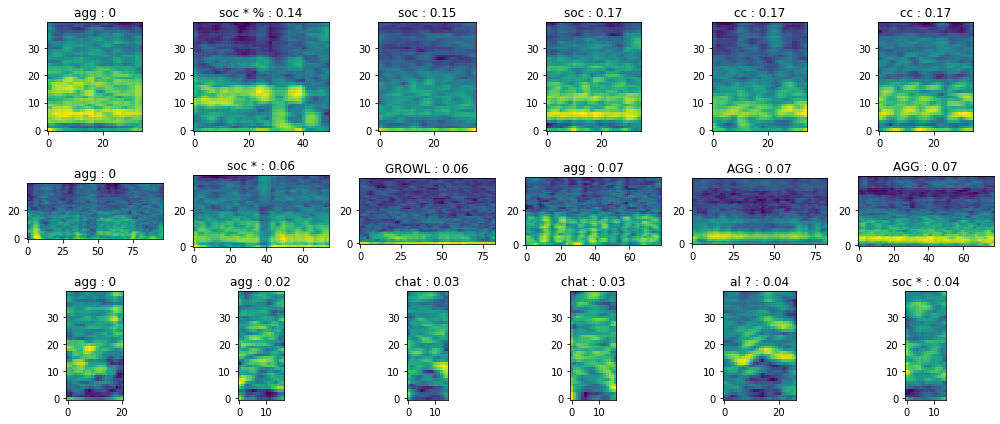

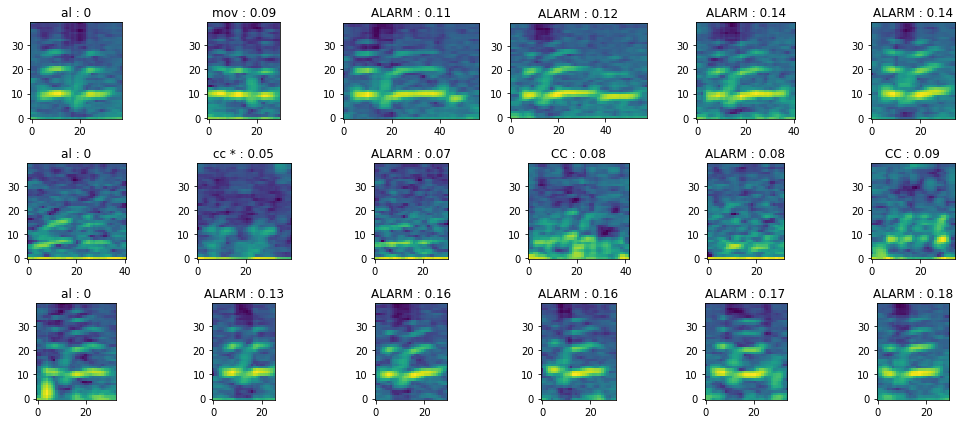

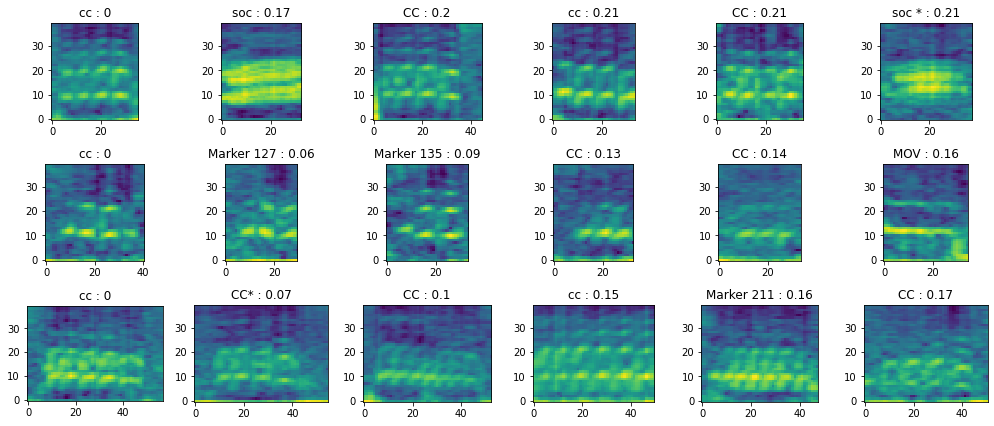

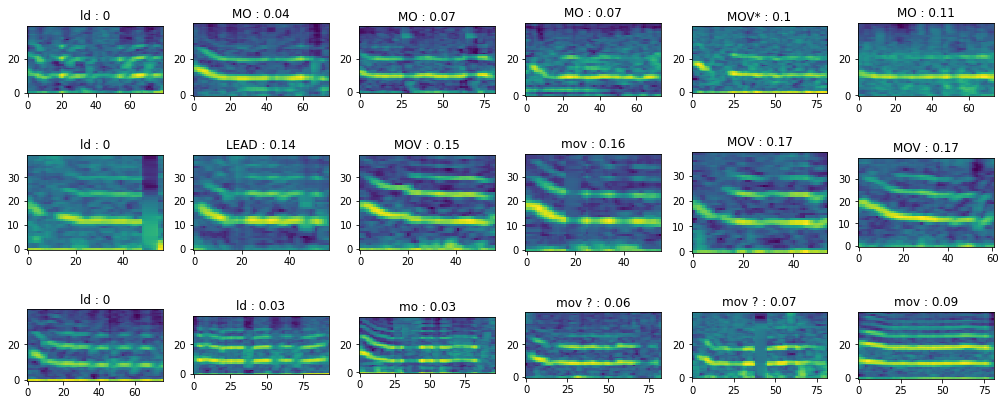

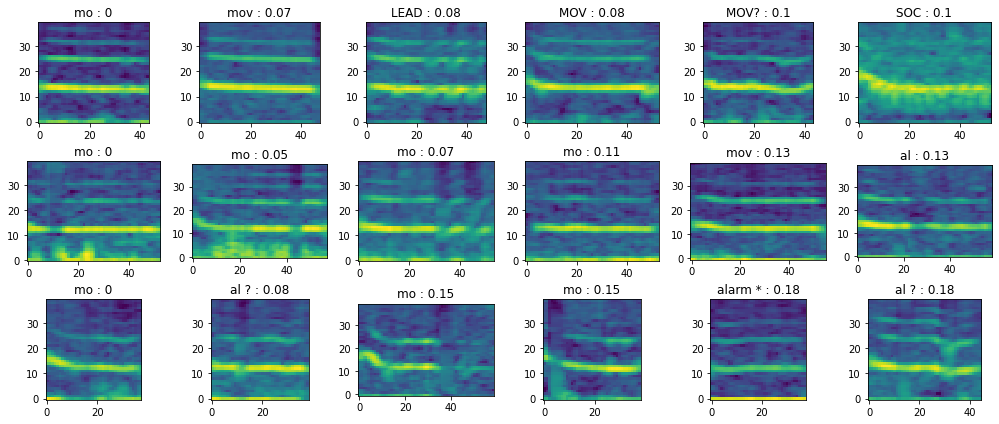

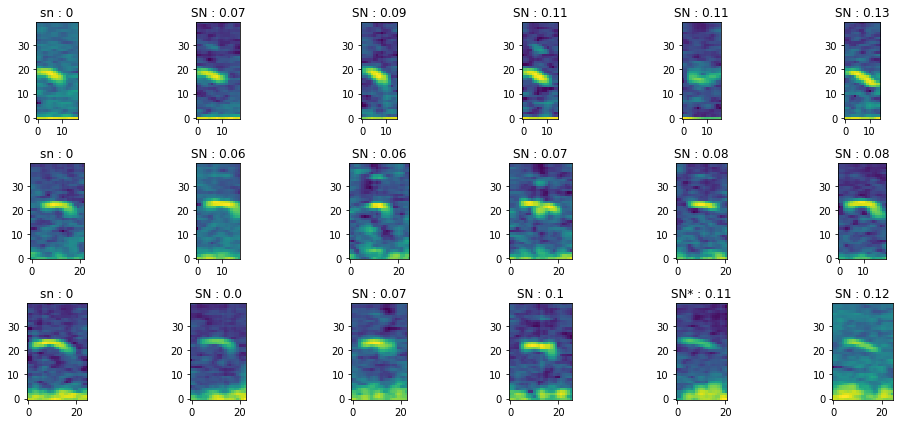

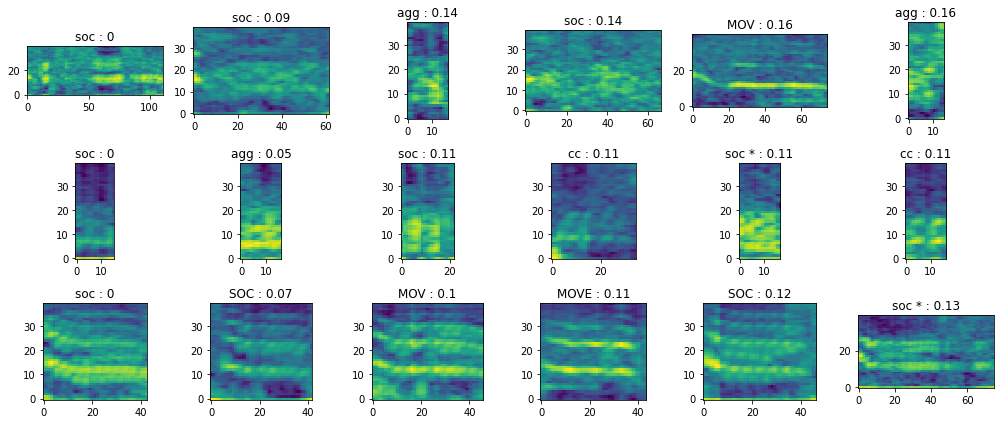

In [ ]:
# make plots

for calltype in calltypes:

  fig = plt.figure(figsize=(14,6))
  fig_name = 'NN_Viz_'+calltype
  k=1
  call_indices = np.asarray(np.where(labels==calltype))[0]

  # randomly choose 3
  example_indices = random.sample(list(call_indices), n_examples)

  for i,ind in enumerate(example_indices):
    img_of_interest = spec_df.iloc[ind,:].denoised_spectrograms
    embedding_of_interest = embedding.iloc[ind,:]
    plt.subplot(n_examples, knn+1, k)
    #librosa.display.specshow(np.transpose(spec))
    plt.imshow(img_of_interest, interpolation='nearest', origin='lower', aspect='equal') 
    plt.title(calltype+' : 0')
    k=k+1

    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = names[neighbor]
      neighbor_embedding = embedding.iloc[neighbor,:]
      dist_to_original = scipy.spatial.distance.euclidean(embedding_of_interest, neighbor_embedding)
      neighbor_img = spec_df.iloc[neighbor,:].denoised_spectrograms
      plt.subplot(n_examples, knn+1, k)
      #librosa.display.specshow(np.transpose(spec))
      plt.imshow(neighbor_img, interpolation='nearest', origin='lower', aspect='equal') 
      plt.title(neighbor_label+' : '+str(round(dist_to_original, 2)))
      k=k+1
        
  plt.tight_layout() 
  plt.savefig(FIGURES+fig_name)

Files for Frants 1

In [ ]:
# Extract calls for Frants!

 Cexample_calls = spec_df.sample(frac=0.003, replace=False, random_state=1)
example_calls_min.shape
example_calls_min.to_pickle(DATA+'example_calls')
for i in range(example_calls_min.shape[0]):
  y = example_calls_min.iloc[i].raw_audio
  sr = example_calls_min.iloc[i].samplerate_hz
  filename = str(example_calls_min.iloc[i].index_id)+'_'+example_calls_min.iloc[i].call_lable+'.wav'

  librosa.output.write_wav(DATA+'frants/'+filename, y, sr, norm=False)

i=4
str(example_calls_min.iloc[i].index_id)+'_'+example_calls_min.iloc[i].call_lable

# Files for Frants 2

In [ ]:
files = os.listdir(DATA+'frants/')

In [ ]:
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load(open("meerkat_channel.json"))

In [ ]:
files = os.listdir(DATA+'frants/')
fileIDs = [int(x.split('_')[0]) for x in files]

In [ ]:
def get_audio(wav_loc, start_s, duration_s):
  # SOUNDFOCs are stereo
  if "SOUNDFOC" in wav_loc:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
  else:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data

In [ ]:
for fileID, filename in zip(fileIDs, files):
  sr = df.loc[df['index_id']==fileID,'samplerate_hz'].values[0]
  dur = df.loc[df['index_id']==fileID,'duration_s'].values[0]
  offset = df.loc[df['index_id']==fileID,'start_s'].values[0]
  wav_loc = df.loc[df['index_id']==fileID,'original_wav'].values[0]

  # add padding
  dur = dur+0.2
  offset = offset-0.1

  y = get_audio(wav_loc, offset, dur)
  librosa.output.write_wav(DATA+'frants_padded/padded_'+filename, y, sr, norm=False)


In [ ]:
fileID

15931

In [ ]:

sr = spec_df.loc[spec_df['index_id']==fileID,'samplerate_hz'].values[0]
dur = spec_df.loc[spec_df['index_id']==fileID,'duration_s'].values[0]
offset = spec_df.loc[spec_df['index_id']==fileID,'start_s'].values[0]
wav_loc = spec_df.loc[spec_df['index_id']==fileID,'original_wav'].values[0]

# add padding
dur = dur+0.2
offset = offset-0.1

y = get_audio(wav_loc, offset, dur)
librosa.output.write_wav(DATA+'frants/padded_'+filename, y, sr, norm=False)


8019


In [ ]:
spec_df.head(3)

Name  ...                                           filename
1598  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1599  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...
1600  ALARM  ...  HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_...

[3 rows x 49 columns]

# Example plots preprocessing

In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
spec_df = df[df.nonfocal_yn == 'n']
spec_df.reset_index(inplace=True)

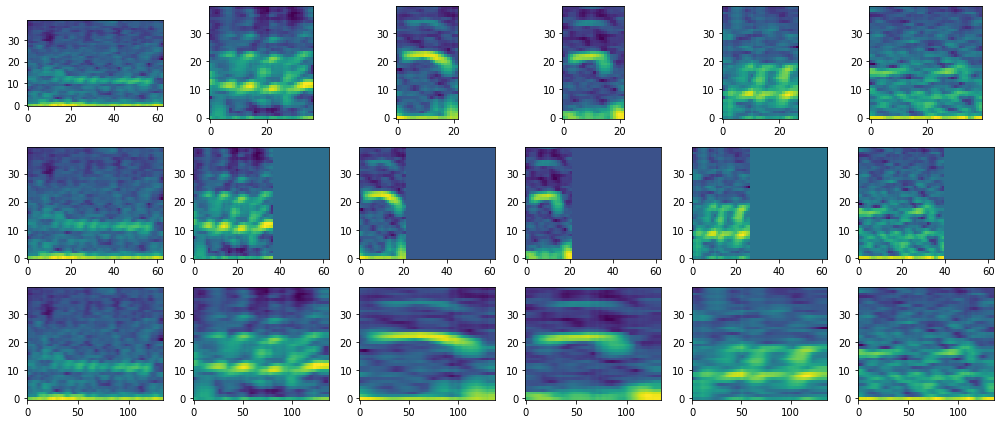

In [ ]:
# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(14,6))
fig_name = 'preprocessing_examples'
k=1

  # randomly choose 4

examples = spec_df.sample(n=6, random_state=1234)
examples.reset_index(inplace=True)

# original 
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_spectrograms
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

stretched = examples.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                        row['samplerate_hz'], 
                                                                        row['duration_s'],
                                                                        N_MELS,
                                                                        WINDOW,
                                                                        FFT_WIN,
                                                                        FFT_HOP),
                           axis=1)

examples['stretched_new'] = stretched
examples['denoised_stretched_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in examples['stretched_new']]



# zero-padded
specs = examples.denoised_spectrograms
maxlen= np.max([spec.shape[1] for spec in specs])
padded_specs = [pad_spectro(spec, maxlen) for spec in specs]

for i in range(examples.shape[0]):
  spec = padded_specs[i]
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1


# stretched
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_stretched_new
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1

plt.tight_layout() 
plt.savefig(FIGURES+fig_name)

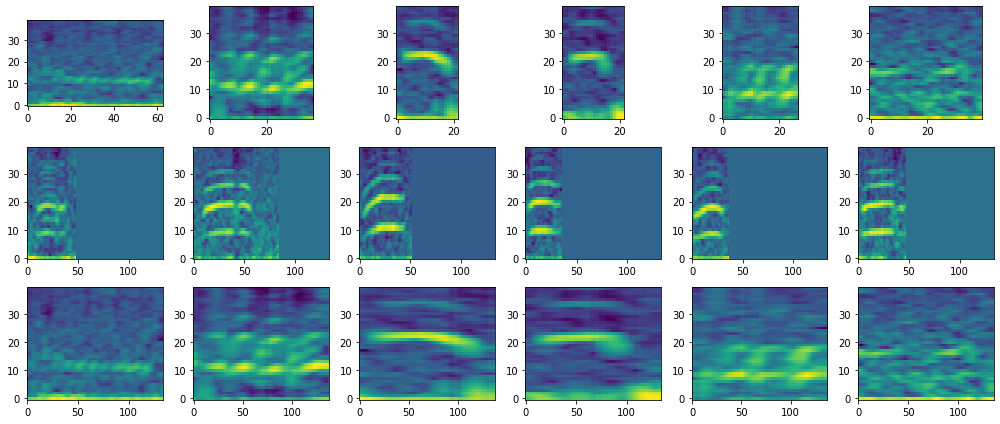

In [ ]:
# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(14,6))
fig_name = 'preprocessing_examples'
k=1

  # randomly choose 4

examples = spec_df.sample(n=6, random_state=1234)
examples.reset_index(inplace=True)

# original 
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_spectrograms
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

stretched = examples.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                        row['samplerate_hz'], 
                                                                        row['duration_s'],
                                                                        N_MELS,
                                                                        WINDOW,
                                                                        FFT_WIN,
                                                                        FFT_HOP),
                           axis=1)

examples['stretched_new'] = stretched
examples['denoised_stretched_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in examples['stretched_new']]



# zero-padded
specs = spec_df.denoised_spectrograms
maxlen= np.max([spec.shape[1] for spec in specs])
padded_specs = [pad_spectro(spec, maxlen) for spec in specs]

for i in range(examples.shape[0]):
  spec = padded_specs[i]
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1


# stretched
for i in range(examples.shape[0]):
  spec = examples.iloc[i,:].denoised_stretched_new
  plt.subplot(3, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
  k=k+1

plt.tight_layout() 
plt.savefig(FIGURES+fig_name)

In [ ]:
@jit(nopython=True)
def preprocess_spec_numba(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec > 3, 3, spec)
    spec = np.where(spec < 0, 0, spec)
    
    return spec

array([[24.188335  , 22.856678  , 18.059265  , ..., 21.389076  ,
        22.148209  , 21.343346  ],
       [12.464241  , 12.01741   ,  9.468864  , ...,  8.198223  ,
         9.503407  ,  8.861595  ],
       [15.790695  , 14.545803  ,  9.023121  , ...,  1.2061462 ,
         5.789692  ,  7.8790054 ],
       ...,
       [-3.3597183 , -3.8820915 , -7.013031  , ..., -0.2532959 ,
        -0.9896965 , -3.693325  ],
       [ 1.0191193 , -0.09102631, -4.9922066 , ..., -1.5644913 ,
        -2.5253372 , -5.223995  ],
       [ 0.58903885, -0.4320488 , -4.494301  , ..., -5.325241  ,
        -5.3667793 , -6.1148605 ]], dtype=float32)

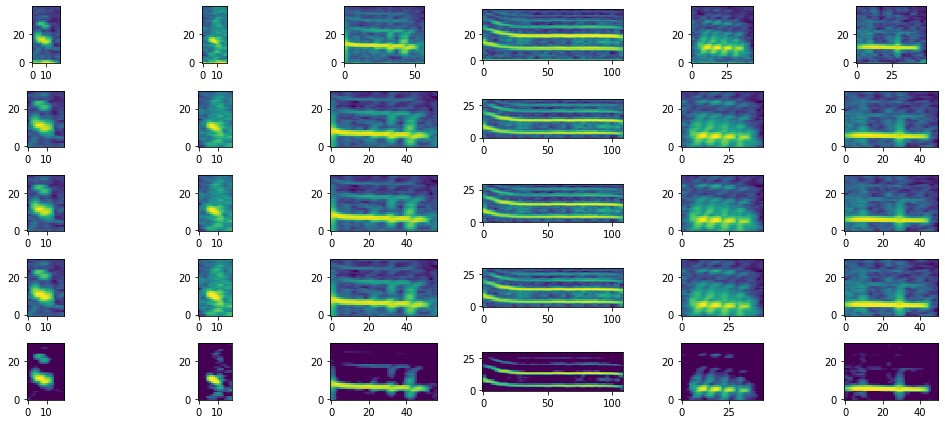

In [ ]:
N_MELS = 40
# make plots
calltypes = sorted(list(set(spec_df.call_lable.values)))

fig = plt.figure(figsize=(14,6))
fig_name = 'preprocessing_examples_mara.png'
k=1

# randomly choose 4
examples = spec_df.sample(n=6, random_state=2222)
examples.reset_index(inplace=True)
ori_specs = examples.spectrograms

# original
for i in range(examples.shape[0]):
  spec = ori_specs[i]
  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# cut
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]

  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# z-score
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
  spec = calc_zscore(spec)
  
  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# floor
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
  spec = calc_zscore(spec)
  spec = np.where(spec > 3, 3, spec)

  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

# ceiling
for i in range(examples.shape[0]):
  spec = ori_specs[i]

  spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
  spec = calc_zscore(spec)
  spec = np.where(spec > 3, 3, spec)
  spec = np.where(spec < 0, 0, spec)
  
  plt.subplot(5, 6, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+1

plt.tight_layout() 
plt.savefig(FIGURES+fig_name)

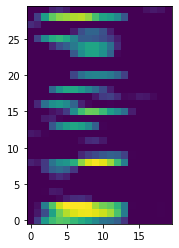

In [ ]:
spec = ori_specs[0]
spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
spec = calc_zscore(spec)
spec = np.where(spec > 3, 3, spec)
spec = np.where(spec < 0, 0, spec)
shuffled = np.copy(spec)
np.random.shuffle(shuffled)
plt.imshow(shuffled, interpolation='nearest', origin='lower', aspect='equal') 